<>:221: SyntaxWarning: invalid escape sequence '\ '
<>:221: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Omar Reda\AppData\Local\Temp\ipykernel_17976\3950439105.py:221: SyntaxWarning: invalid escape sequence '\ '
  \            /


Saved paper 1 -> ../data/papers/1.jpg
Saved paper 2 -> ../data/papers/2.jpg
Saved paper 3 -> ../data/papers/3.jpg
Saved paper 4 -> ../data/papers/4.jpg
Saved paper 5 -> ../data/papers/5.jpg
Saved paper 6 -> ../data/papers/6.jpg
Saved paper 7 -> ../data/papers/7.jpg
Saved paper 8 -> ../data/papers/8.jpg
Saved paper 9 -> ../data/papers/9.jpg
Saved paper 10 -> ../data/papers/10.jpg
Saved paper 11 -> ../data/papers/11.jpg
Saved paper 12 -> ../data/papers/12.jpg
Saved paper 13 -> ../data/papers/13.jpg
Saved paper 14 -> ../data/papers/14.jpg
Saved paper 15 -> ../data/papers/15.jpg
Saved paper 16 -> ../data/papers/16.jpg
Saved paper 17 -> ../data/papers/17.jpg
Saved paper 18 -> ../data/papers/18.jpg
Saved paper 19 -> ../data/papers/19.jpg
Saved paper 20 -> ../data/papers/20.jpg
Saved paper 21 -> ../data/papers/21.jpg
Saved paper 22 -> ../data/papers/22.jpg
Saved paper 23 -> ../data/papers/23.jpg
Saved paper 24 -> ../data/papers/24.jpg


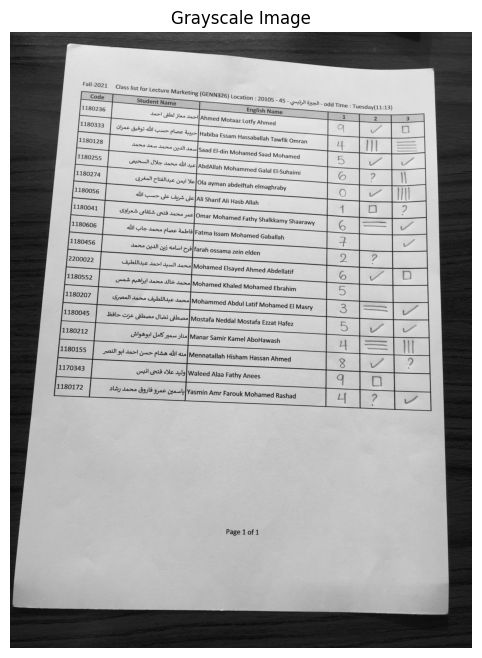

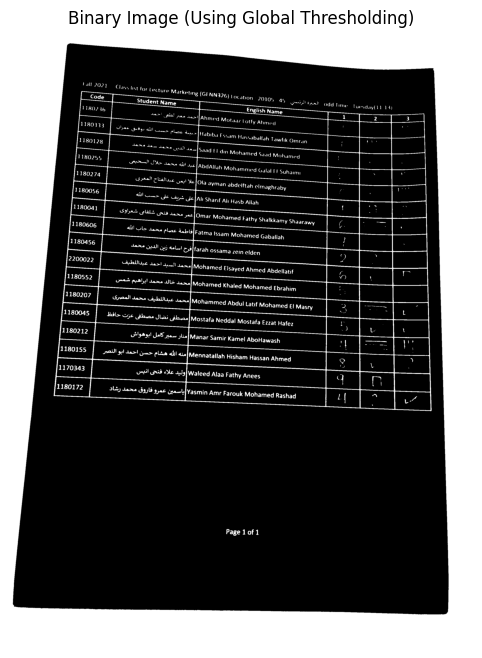

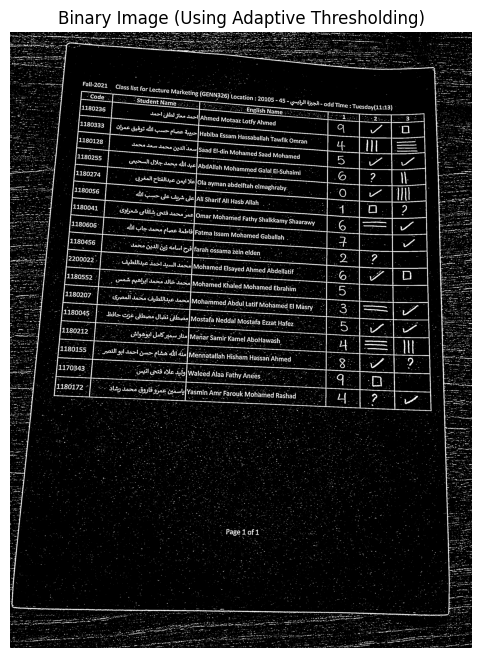

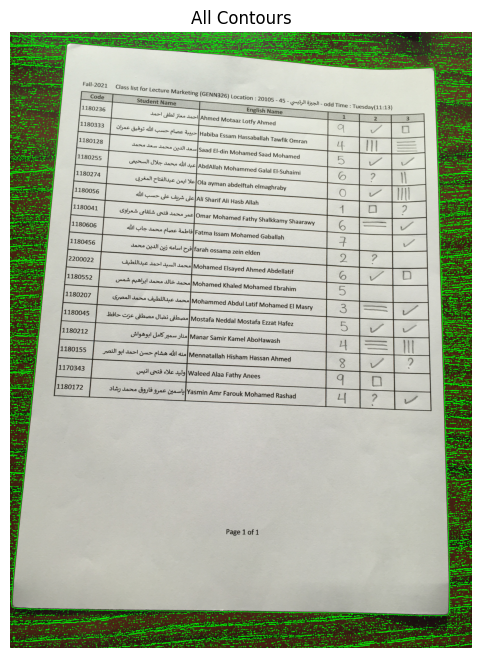

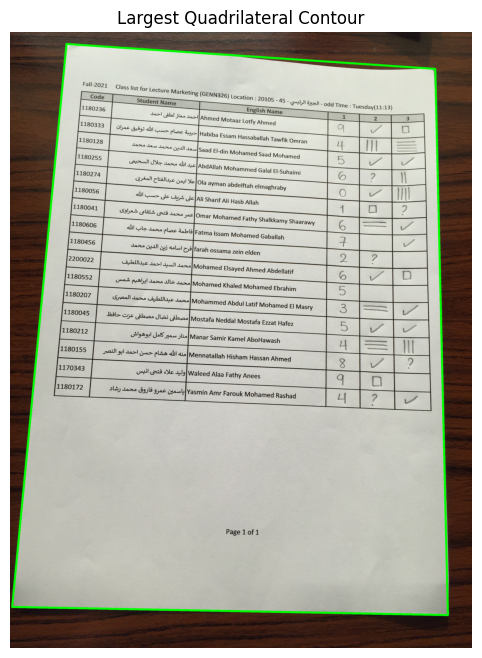

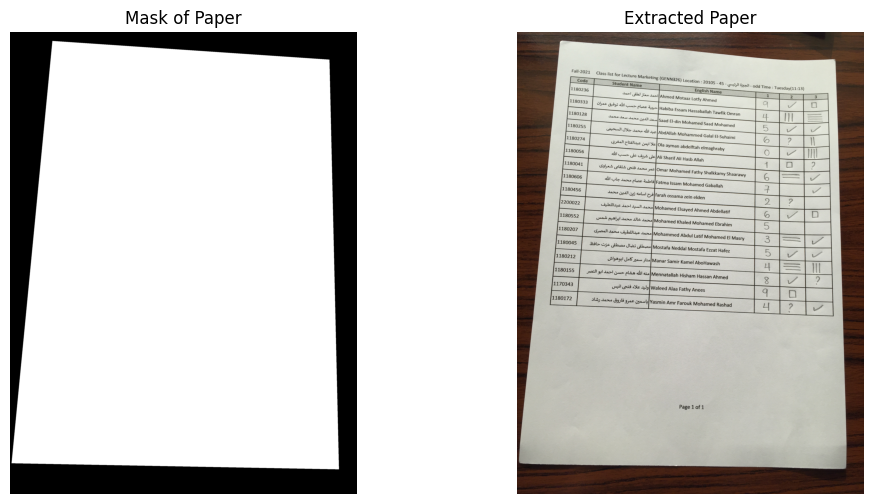

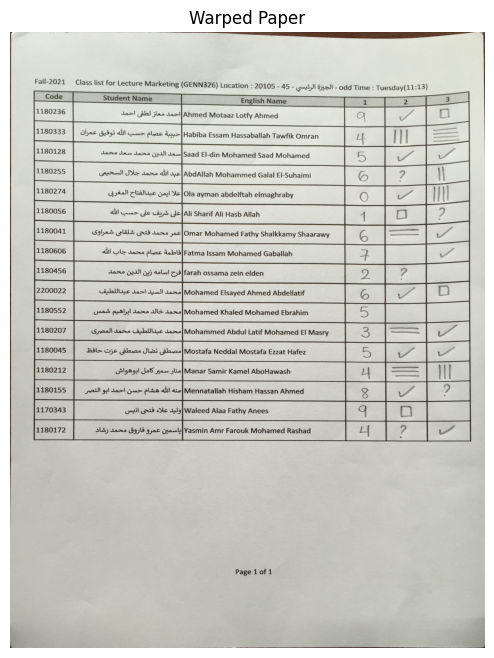

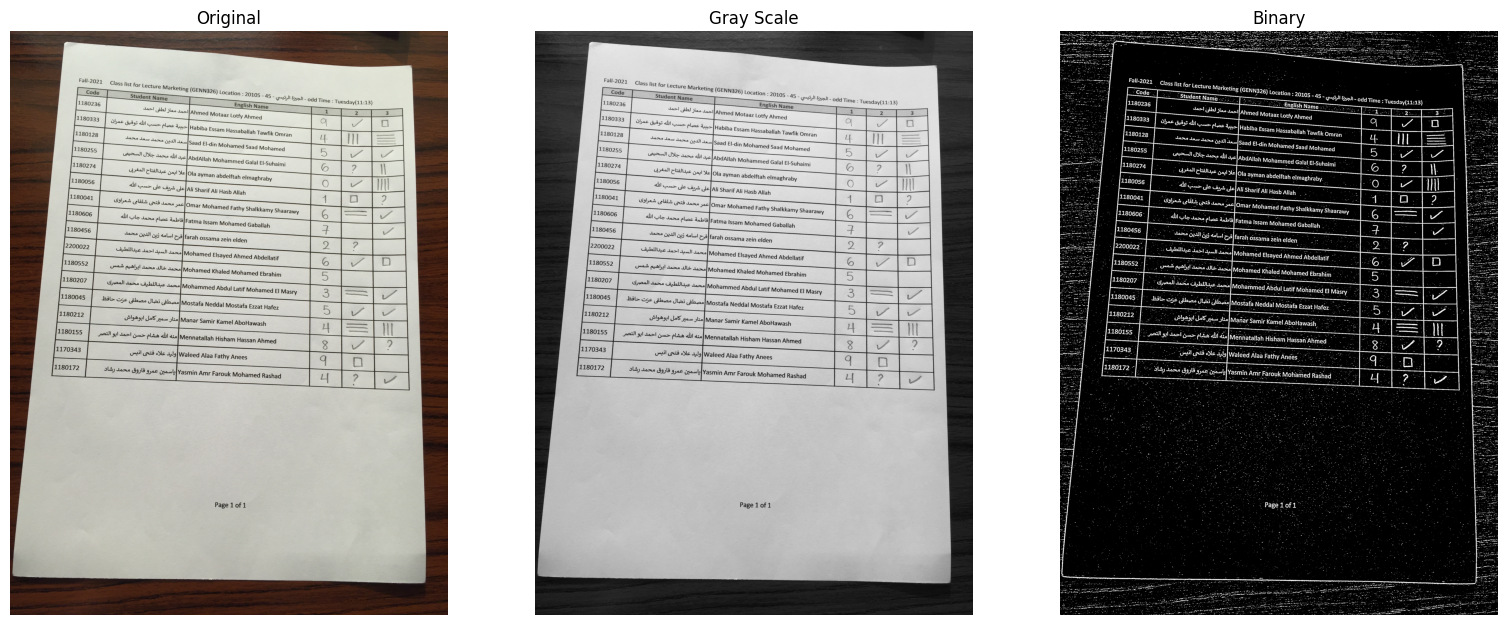

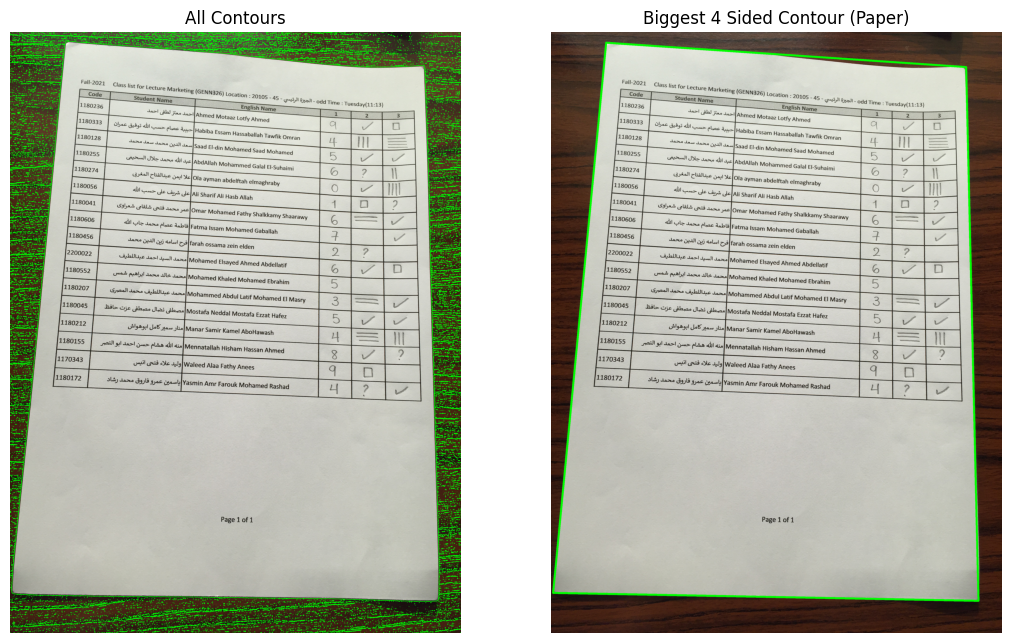

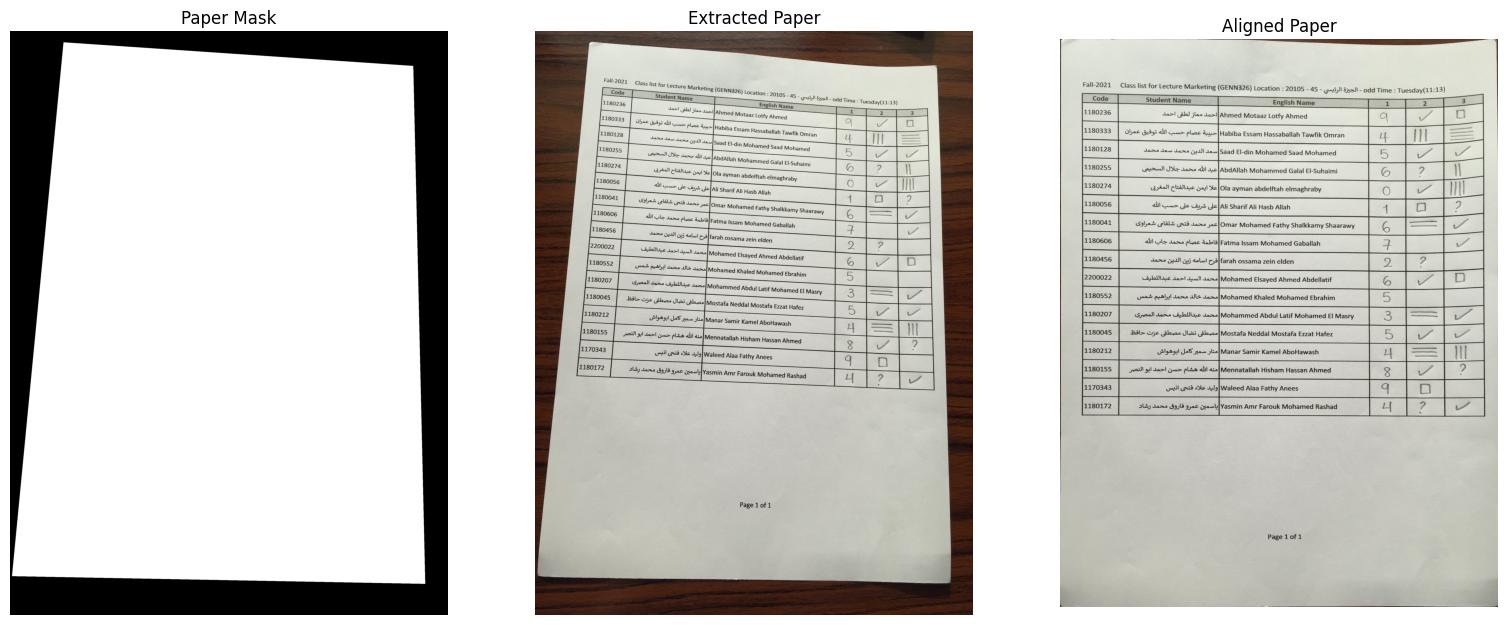

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *

images = ["../data/images/1.jpg", "../data/images/2.jpg", "../data/images/3.jpg", "../data/images/4.jpg", "../data/images/5.jpg", "../data/images/6.jpg", "../data/images/7.jpg", 
          "../data/images/8.jpg", "../data/images/9.jpg", "../data/images/10.jpg", "../data/images/11.jpg", "../data/images/12.jpg", "../data/images/13.jpg", "../data/images/14.jpg", 
          "../data/images/15.jpg", "../data/images/16.jpg", "../data/images/17.jpg", "../data/images/18.jpg", "../data/images/19.jpg", "../data/images/20.jpg",
        "../data/images/21.jpg", "../data/images/22.jpg", "../data/images/23.jpg", "../data/images/24.jpg"]

# Create papers folder
papers_dir = "../data/papers"
os.makedirs(papers_dir, exist_ok=True)

for i, imagePath in enumerate(images):

    # Reading image and converting to RGB format since cv reads in BGR format
    imageBGR = cv.imread(imagePath)
    imageRGB = cv.cvtColor(imageBGR, cv.COLOR_BGR2RGB)

    # Converting to grayscale
    imageGrayScale = cv.cvtColor(imageRGB, cv.COLOR_BGR2GRAY)

    # Applying gaussian filter
    img_gray = cv.GaussianBlur(imageGrayScale, (7, 7), 0)

    # Adaptive thresholding
    thresh = cv.adaptiveThreshold(
        img_gray, 255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        11, 2
    )

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Finding the biggest 4-sided contour
    maxContourArea = 0
    biggestContour = None

    for contour in contours:
        area = cv.contourArea(contour)
        peri = cv.arcLength(contour, True)
        constructedPoly = cv.approxPolyDP(contour, 0.02 * peri, True)

        if len(constructedPoly) == 4 and area > maxContourArea:
            maxContourArea = area
            biggestContour = constructedPoly

    if biggestContour is None:
        print(f"Paper not detected in image {i+1}")
        continue

    # Masking the paper
    mask = np.zeros_like(img_gray)
    cv.fillPoly(mask, [biggestContour], 255)
    extractedPaper = cv.bitwise_and(imageRGB, imageRGB, mask)

    # Reorder contour points
    contourPoints = biggestContour.reshape(4, 2)
    contourPoints = sorted(contourPoints, key=lambda p: p[1])

    top = contourPoints[:2]
    bottom = contourPoints[2:]

    topLeft, topRight = sorted(top, key=lambda p: p[0])
    bottomLeft, bottomRight = sorted(bottom, key=lambda p: p[0])

    orderedPoints = np.float32([topLeft, topRight, bottomLeft, bottomRight])

    # Compute width and height
    leftEdge = np.linalg.norm(topLeft - bottomLeft)
    rightEdge = np.linalg.norm(topRight - bottomRight)
    topEdge = np.linalg.norm(topLeft - topRight)
    bottomEdge = np.linalg.norm(bottomLeft - bottomRight)

    width = int(max(topEdge, bottomEdge))
    height = int(max(leftEdge, rightEdge))

    destinationPoints = np.float32([
        [0, 0],
        [width, 0],
        [0, height],
        [width, height]
    ])

    # Perspective transform
    matrix = cv.getPerspectiveTransform(orderedPoints, destinationPoints)
    croppedPaper = cv.warpPerspective(imageRGB, matrix, (width, height))

    save_path = f"{papers_dir}/{i+1}.jpg"
    cv.imwrite(save_path, cv.cvtColor(croppedPaper, cv.COLOR_RGB2BGR))

    print(f"Saved paper {i+1} -> {save_path}")

plt.show()

# Converting to grayscale
imageGrayScale = cv.cvtColor(imageRGB, cv.COLOR_BGR2GRAY)

# Displaying grayscale image
plt.figure(figsize = (10, 8))
plt.imshow(imageGrayScale, cmap = 'gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

# Applying gaussian filter to reduce noise and needed so that noise is not detected as contours
img_gray = cv.GaussianBlur(imageGrayScale, (7, 7), 0)

# Testing global thresholding to seperate foregound from background
# Noticed from results that global thresholding fails to segment the image properly in different lighting or shadowy photos
_, globalThresholded = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY_INV)

plt.figure(figsize = (10, 8))
plt.imshow(globalThresholded, cmap = 'gray')
plt.title("Binary Image (Using Global Thresholding)")
plt.axis('off')
plt.show()

# Testing adaptive thresholding and from results it is more accurate than global thresholding especially in different lighting or shadowy photos
# Recall segmentation lec and lab
thresh = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
plt.figure(figsize = (10, 8))
plt.imshow(thresh, cmap = 'gray')
plt.title("Binary Image (Using Adaptive Thresholding)")
plt.axis('off')
plt.show()

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL ,cv.CHAIN_APPROX_SIMPLE)

# Make a copy of original image to draw on
imageContours = imageRGB.copy()

# Drawing all contours in green
cv.drawContours(imageContours, contours, -1, (0, 255, 0), 2)

plt.figure(figsize = (10, 8))
plt.imshow(imageContours)
plt.title("All Contours")
plt.axis('off')
plt.show()

# Finding the biggest 4 sided contour
maxContourArea = 0
biggestContour = None

for contour in contours:
    area = cv.contourArea(contour)
    peri = cv.arcLength(contour, True)
    constructedPoly = cv.approxPolyDP(contour, 0.02 * peri, True)  # approximates contour to a polygon

    if len(constructedPoly) == 4:
        if area > maxContourArea:
            maxContourArea = area
            biggestContour = constructedPoly

# Drawing the largest contour
biggestContourImage = imageRGB.copy()
cv.drawContours(biggestContourImage, [biggestContour], -1, (0, 255, 0), 10)  # green contour

plt.figure(figsize = (10, 8))
plt.imshow(biggestContourImage)
plt.title("Largest Quadrilateral Contour")
plt.axis('off')
plt.show()

# Masking the paper
mask = np.zeros_like(img_gray)
cv.fillPoly(mask, [biggestContour], 255)

extractedPaper = cv.bitwise_and(imageRGB, imageRGB, mask)

# Displaying the mask and extracted paper
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Mask of Paper")
plt.imshow(mask, cmap = 'gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Extracted Paper")
plt.imshow(extractedPaper)
plt.axis('off')
plt.show()

# Reorder points: top-left, top-right, bottom-left, bottom-right
# [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
contourPoints = biggestContour.copy().reshape(4, 2)

# Separate top and bottom points by y-coordinate
contourPoints = list(contourPoints)
contourPoints.sort(key = lambda p: p[1])  # Sorting by y-coordinate

top = contourPoints[:2]     # top two points (smallest y)
bottom = contourPoints[2:]  # bottom two points (largest y)

# Getting Top Left and Top Right
if top[0][0] < top[1][0]:
    topLeft, topRight = top[0], top[1]
else:
    topLeft, topRight = top[1], top[0]

# Getting Bottom Left and Bottom Right
if bottom[0][0] < bottom[1][0]:
    bottomLeft, bottomRight = bottom[0], bottom[1]
else:
    bottomLeft, bottomRight = bottom[1], bottom[0]

# Final ordered points
orderedPoints = [topLeft, topRight, bottomLeft, bottomRight]

# Compute width and height of new image
topLeft, topRight, bottomLeft, bottomRight = orderedPoints[0], orderedPoints[1], orderedPoints[2], orderedPoints[3]

# Our result image should be the longest vertical edge * longest horizontal edge
'''
pts[0] -------- pts[1]
   \            /
    \          /
    pts[2] --- pts[3]

'''

leftEdge = (((topLeft[0] - bottomLeft[0]) ** 2) + ((topLeft[1] - bottomLeft[1]) ** 2)) ** (1/2)
rightEdge = (((topRight[0] - bottomRight[0]) ** 2) + ((topRight[1] - bottomRight[1]) ** 2)) ** 0.5

topEdge = (((topLeft[0] - topRight[0]) ** 2) + ((topLeft[1] - topRight[1]) ** 2)) ** 0.5

bottomEdge = (((bottomLeft[0] - bottomRight[0]) ** 2) + ((bottomLeft[1] - bottomRight[1]) ** 2)) ** 0.5

width = int(max(topEdge, bottomEdge))
height = int(max(leftEdge, rightEdge))

# Destination points for warp
# Top left, Top right, Bottom left, Bottom right
destinationPoints = np.float32([[0, 0],[width, 0],[0, height],[width, height]])

# Compute perspective transform matrix
orderedPoints = np.float32(orderedPoints)
matrix = cv.getPerspectiveTransform(orderedPoints, destinationPoints)

# Warp the extracted paper
croppedPaper = cv.warpPerspective(imageRGB, matrix, (width, height))

# Show result
plt.figure(figsize = (10, 8))
plt.imshow(croppedPaper)
plt.title("Warped Paper")
plt.axis('off')
plt.show()

# Result pipeline
show_images([imageRGB, imageGrayScale, thresh], titles = ["Original", "Gray Scale", "Binary"])
show_images([imageContours, biggestContourImage], titles = ["All Contours", "Biggest 4 Sided Contour (Paper)"])
show_images([mask, extractedPaper, croppedPaper], titles = ["Paper Mask", "Extracted Paper", "Aligned Paper"])